### Opening tensorboard if necessary

In [ ]:
"""
# not working on compute4 :( 
%load_ext tensorboard
%tensorboard --logdir logs
"""

# Init: opening measurement file and creating synthetic dataset

In [1]:
# imports libraries
import time
import tensorflow as tf # tensorflow 2.10
import numpy as np # numpy 1.21.5
import matplotlib.pyplot as plt
import random
import datetime
import json

# my imports
from data_generation import get_sample, get_sample2 
from evals_WGANGP import evals_WGANGP
from evals_dB_WGANGP import evals_dB_WGANGP
from evecs_WGANGP import evecs_WGANGP
from main_evecs_WGANGP import main_evecs_WGANGP
from noise_evecs_WGANGP import noise_evecs_WGANGP
from measurement import get_measurement_sample
from eigenmanipulation import normalize_evals, normalize_evecs, levelify, unlevelify
from beamforming import beamform, beamform_difference, get_csm, get_rank_I_csm
from plotting_loss import plot_loss
from data_augmentation import get_augmented_csm_from_eval, get_augmented_csm_from_evec

# config files
from msm_config2022 import FILES, LOC # config file for measurements with names 2022- ... .h5


# ==============================================================================================================
# Code necessary to prevent the container from occupying the whole GPU RAM.
# ==============================================================================================================

gpu_available = tf.config.list_physical_devices('GPU')

# only occupy needed GPU RAM 
for gpu in gpu_available:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Generate datasets

# noise file: 2022-01-26_16-22-57_076675.h5
"""
start = time.time()

filename_examples = ["2022-01-26_16-44-23_105567.h5",
                    "2022-01-26_16-37-41_557896.h5",
                    "2022-01-26_16-41-15_436578.h5",
                    "2022-01-26_16-27-11_017085.h5",
                    "2022-01-26_16-21-22_252111.h5",
                    "2022-01-26_16-21-05_110135.h5",
                    "2022-01-26_16-18-19_438409.h5"]


# General variable
BATCH_SIZE = 1#16
NB_SYNTHETIC_BATCH = 1#1000 # for the synthetic dataset
NB_MEASUREMENT_BATCH = 1#200 # for the measurement dataset
NB_STEPS = 1#5

# Variables to access the measurements
MEASUREMENT_PATH = "../Data/Measurement/td/"
MEASUREMENT_PATH_C4 = "../../../shared/measured_data/td/"
index = 3#np.random.randint(len(filename_examples))
FILENAME = filename_examples[index]
print(f"measurement used: {FILENAME[:-3]}")
MEASUREMENT_NAME = f"{MEASUREMENT_PATH}{FILENAME}"

# Data to use
loc_dict = {f"{name}.h5": loc for name, loc in zip(FILES, LOC)}
loc = loc_dict[FILENAME]

BLOCKSIZE = 128
APERTURE_SIZE = 1.4648587220804408#1.5 # measurement
SPEED_OF_SOUND = 343 #[m/s]
SAMPLING_FREQUENCY = 51200 # measurement 2022
LOCATION_MEASUREMENT=(loc[0], loc[1], 0.5*APERTURE_SIZE) # location of the sound source in measurement
LOCATION_SYNTHETIC = (loc[0]/APERTURE_SIZE, loc[1]/APERTURE_SIZE, 0.5) # location of the sound source in synthetic
HELMOTZ_NUMBER = 16




# Generating synthetic dataset

synthetic_dataset = [get_sample2(loc=LOCATION_SYNTHETIC, 
                                 helmotz_number=HELMOTZ_NUMBER)
                     for _ in range(BATCH_SIZE*NB_SYNTHETIC_BATCH)]



main_evecs_dataset = tf.convert_to_tensor([s[0] for s in synthetic_dataset])
noise_evecs_dataset = tf.convert_to_tensor([s[1] for s in synthetic_dataset])
evals_dataset = tf.convert_to_tensor([s[2] for s in synthetic_dataset])
evals_dB_dataset = tf.convert_to_tensor([s[3] for s in synthetic_dataset])

# Opening measurement dataset

measurement_dataset = [get_measurement_sample(measurement_name=MEASUREMENT_NAME,
                                             helmotz_number=HELMOTZ_NUMBER)
                       for _ in range(BATCH_SIZE*NB_MEASUREMENT_BATCH)]

measurement_main_evecs_dataset = tf.convert_to_tensor([m[0] for m in measurement_dataset])
measurement_noise_evecs_dataset = tf.convert_to_tensor([m[1] for m in measurement_dataset])
measurement_evals_dataset = tf.convert_to_tensor([m[2] for m in measurement_dataset])
measurement_evals_dB_dataset = tf.convert_to_tensor([m[3] for m in measurement_dataset])

diff = time.time() - start
print(f"completed in {diff}s")
"""

'\nstart = time.time()\n\nfilename_examples = ["2022-01-26_16-44-23_105567.h5",\n                    "2022-01-26_16-37-41_557896.h5",\n                    "2022-01-26_16-41-15_436578.h5",\n                    "2022-01-26_16-27-11_017085.h5",\n                    "2022-01-26_16-21-22_252111.h5",\n                    "2022-01-26_16-21-05_110135.h5",\n                    "2022-01-26_16-18-19_438409.h5"]\n\n\n# General variable\nBATCH_SIZE = 1#16\nNB_SYNTHETIC_BATCH = 1#1000 # for the synthetic dataset\nNB_MEASUREMENT_BATCH = 1#200 # for the measurement dataset\nNB_STEPS = 1#5\n\n# Variables to access the measurements\nMEASUREMENT_PATH = "../Data/Measurement/td/"\nMEASUREMENT_PATH_C4 = "../../../shared/measured_data/td/"\nindex = 3#np.random.randint(len(filename_examples))\nFILENAME = filename_examples[index]\nprint(f"measurement used: {FILENAME[:-3]}")\nMEASUREMENT_NAME = f"{MEASUREMENT_PATH}{FILENAME}"\n\n# Data to use\nloc_dict = {f"{name}.h5": loc for name, loc in zip(FILES, LOC)}\nloc

In [3]:
# Generate datasets for multiple evals decay

# noise file: 2022-01-26_16-22-57_076675.h5
"""
FILES = ["2022-01-26_14-05-30_205318",X
"2022-01-26_14-15-20_571501",X
"2022-01-26_14-20-26_610643",
"2022-01-26_14-29-34_101584",
"2022-01-26_14-37-01_171279",
"2022-01-26_14-41-40_709901",
"2022-01-26_14-44-52_692688",X
"2022-01-26_14-49-34_190284",
"2022-01-26_14-52-20_198146",
"2022-01-26_15-00-05_573065",
"2022-01-26_15-03-17_262249",
"2022-01-26_15-05-59_807071",
"2022-01-26_15-08-59_270950",
"2022-01-26_15-12-11_105482",X
"2022-01-26_15-14-45_317892",X
"2022-01-26_15-27-38_780884",0
"2022-01-26_15-30-06_258641",0
"2022-01-26_15-33-16_836936",0
"2022-01-26_15-36-20_468472",0
"2022-01-26_15-38-58_850535",0
"2022-01-26_15-43-21_931768",0
"2022-01-26_15-47-39_208877",0
"2022-01-26_15-50-14_403984",0
"2022-01-26_15-53-54_277933",0
"2022-01-26_15-56-50_918805",0
"2022-01-26_16-06-10_919544",0
"2022-01-26_16-09-42_285967",0
"2022-01-26_16-12-24_903641",0
"2022-01-26_16-15-28_316108",0
"2022-01-26_16-18-19_438409"0,
"2022-01-26_16-21-05_110135",0
"2022-01-26_16-21-22_252111",0
"2022-01-26_16-27-11_017085",0
"2022-01-26_16-41-15_436578",0
"2022-01-26_16-37-41_557896",0
"2022-01-26_16-44-23_105567"]0
"""

FILES_H5 = [f"{filename}.h5" for filename in FILES]

start = time.time()

list_tensor = []

filename_examples = ["2022-01-26_15-27-38_780884.h5",
                    "2022-01-26_15-30-06_258641.h5",
                    "2022-01-26_15-33-16_836936.h5",
                    "2022-01-26_15-36-20_468472.h5",
                    "2022-01-26_15-38-58_850535.h5",
                    "2022-01-26_15-43-21_931768.h5",
                    "2022-01-26_15-47-39_208877.h5",
                    "2022-01-26_15-50-14_403984.h5",
                    "2022-01-26_15-53-54_277933.h5",
                    "2022-01-26_15-56-50_918805.h5",
                    "2022-01-26_16-06-10_919544.h5",
                    "2022-01-26_16-09-42_285967.h5",
                    "2022-01-26_16-12-24_903641.h5",
                    "2022-01-26_16-15-28_316108.h5",
                    "2022-01-26_16-21-05_110135.h5",
                    "2022-01-26_16-44-23_105567.h5",
                    "2022-01-26_16-37-41_557896.h5",
                    "2022-01-26_16-41-15_436578.h5",
                    "2022-01-26_16-27-11_017085.h5",
                    "2022-01-26_16-21-22_252111.h5",
                    "2022-01-26_16-21-05_110135.h5",
                    "2022-01-26_16-18-19_438409.h5",
                    "2022-01-26_16-37-41_557896.h5"]

for filename in filename_examples:
    
    print(filename)

    # General variable
    BATCH_SIZE = 1
    #NB_SYNTHETIC_BATCH = 1000 # for the synthetic dataset
    NB_MEASUREMENT_BATCH = 1 # for the measurement dataset

    # Variables to access the measurements
    MEASUREMENT_PATH = "../Data/Measurement/td/"
    MEASUREMENT_PATH_C4 = "../../../shared/measured_data/td/"
    #index = 3#np.random.randint(len(filename_examples))
    #FILENAME = filename_examples[index]
    #print(f"measurement used: {FILENAME[:-3]}")
    MEASUREMENT_NAME = f"{MEASUREMENT_PATH}{filename}"

    # Data to use
    loc_dict = {f"{name}.h5": loc for name, loc in zip(FILES, LOC)}
    loc = loc_dict[filename]
    #FREQ_INDEX = 63
    BLOCKSIZE = 128
    APERTURE_SIZE = 1.4648587220804408 #1.5 # measurement
    SPEED_OF_SOUND = 343 #[m/s]
    SAMPLING_FREQUENCY = 51200 # measurement 2022
    LOCATION_MEASUREMENT=(loc[0], loc[1], 0.5*APERTURE_SIZE) # location of the sound source in measurement
    #LOCATION_SYNTHETIC = (loc[0]/APERTURE_SIZE, loc[1]/APERTURE_SIZE, 0.5) # location of the sound source in synthetic
    HELMOTZ_NUMBER = 16

    # Opening measurement dataset

    measurement_dataset = [get_measurement_sample(measurement_name=MEASUREMENT_NAME,
                                                 helmotz_number=HELMOTZ_NUMBER)]

    #measurement_main_evecs_dataset = tf.convert_to_tensor([m[0] for m in measurement_dataset])
    #measurement_noise_evecs_dataset = tf.convert_to_tensor([m[1] for m in measurement_dataset])
    #measurement_evals_dataset = tf.convert_to_tensor([m[2] for m in measurement_dataset])
    measurement_evals_dB_dataset = tf.convert_to_tensor([m[3] for m in measurement_dataset])
    
    list_tensor.append(measurement_evals_dB_dataset)

diff = time.time() - start
print(f"completed in {diff}s")
    

2022-01-26_15-27-38_780884.h5
[('2022-01-26_15-27-38_780884_cache.h5', 1)]
(0.001815559693342365+0j)
2022-01-26_15-30-06_258641.h5


2023-02-04 15:11:26.953596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 15:11:26.954658: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


[('2022-01-26_15-30-06_258641_cache.h5', 1)]
(0.0029908963116277733+0j)
2022-01-26_15-33-16_836936.h5
[('2022-01-26_15-33-16_836936_cache.h5', 1)]
(0.004243620559078198+0j)
2022-01-26_15-36-20_468472.h5
[('2022-01-26_15-36-20_468472_cache.h5', 1)]
(0.00559370583448958+0j)
2022-01-26_15-38-58_850535.h5
[('2022-01-26_15-38-58_850535_cache.h5', 1)]
(0.007628013255490107+0j)
2022-01-26_15-43-21_931768.h5
[('2022-01-26_15-43-21_931768_cache.h5', 1)]
(0.00987567299161578+0j)
2022-01-26_15-47-39_208877.h5
[('2022-01-26_15-47-39_208877_cache.h5', 1)]
(0.010257455289134606+0j)
2022-01-26_15-50-14_403984.h5
[('2022-01-26_15-50-14_403984_cache.h5', 1)]
(0.010416176185665+0j)
2022-01-26_15-53-54_277933.h5
[('2022-01-26_15-53-54_277933_cache.h5', 1)]
(0.011034241456672754+0j)
2022-01-26_15-56-50_918805.h5
[('2022-01-26_15-56-50_918805_cache.h5', 1)]
(0.011052387785718513+0j)
2022-01-26_16-06-10_919544.h5
[('2022-01-26_16-06-10_919544_cache.h5', 1)]
(0.010379453988350145+0j)
2022-01-26_16-09-42_2859

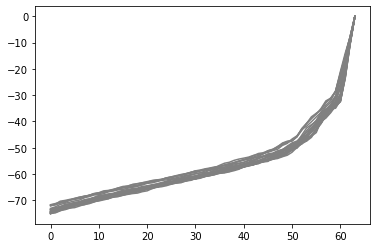

In [4]:
level_decay = []

for tensor in list_tensor:
    a = np.sort(np.array(tensor[0,:,:,0]).flatten())
    level_decay.append(a)
    #print(tensor.shape)

ballec = [plt.plot(a, color = "grey") for a in level_decay]

In [ ]:
# Beamforming validation test + eval check ====================================================================
"""
NUMFREQ = 1
NUMCHANNELS = 64
figsize_throwaway = (12,4)


# 1 with synthetic ============================================================================================
print(f"synthetic source is located at (x,y) = ({LOCATION_SYNTHETIC[0]},{LOCATION_SYNTHETIC[1]})")

fig = plt.figure(figsize=figsize_throwaway)

evals_ex = evals_dataset[0]
noise_evecs_ex = noise_evecs_dataset[0]
main_evecs_ex = main_evecs_dataset[0]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-2)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

synthetic_csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
synthetic_csm = np.reshape(synthetic_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

plt.subplot(121)
beamform(synthetic_csm, helmotz_number=HELMOTZ_NUMBER, measurement=False)

plt.subplot(122)
plt.plot(levelify(evals_vec_numpy))
plt.suptitle("Synthetic")

# 2 with measurement ===========================================================================================
print(f"measurement source is located at (x,y) = ({LOCATION_MEASUREMENT[0]},{LOCATION_MEASUREMENT[1]})")

fig = plt.figure(figsize=figsize_throwaway)

evals_ex = measurement_evals_dataset[0]
noise_evecs_ex = measurement_noise_evecs_dataset[0]
main_evecs_ex = measurement_main_evecs_dataset[0]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-2)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

measurement_csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
measurement_csm = np.reshape(measurement_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

plt.subplot(121)
beamform(measurement_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)

plt.subplot(122)
plt.plot(levelify(evals_vec_numpy))
plt.suptitle("Measurement")
"""

### Misc: function to save and load datasets instead of generating them

In [ ]:
# Save datasets:
"""
datasets = [main_evecs_dataset,
            noise_evecs_dataset,
            evals_dataset,
            evals_dB_dataset,
            measurement_main_evecs_dataset,
            measurement_noise_evecs_dataset,
            measurement_evals_dataset,
            measurement_evals_dB_dataset]

name_datasets = ["main_evecs_dataset",
                "noise_evecs_dataset",
                "evals_dataset",
                "evals_dB_dataset",
                "measurement_main_evecs_dataset",
                "measurement_noise_evecs_dataset",
                "measurement_evals_dataset",
                "measurement_evals_dB_dataset"]

for dataset, name in zip(datasets, name_datasets):
    numpy_dataset = np.array(dataset)
    with open(f'datasets_backups/{name}.npy', 'wb') as f:
        np.save(f, numpy_dataset)
      
        


variable_dict = {
        "BATCH_SIZE":BATCH_SIZE,
        "NB_SYNTHETIC_BATCH":NB_SYNTHETIC_BATCH,
        "NB_MEASUREMENT_BATCH":NB_MEASUREMENT_BATCH,
        "NB_STEPS":NB_STEPS,
        "MEASUREMENT_PATH":MEASUREMENT_PATH,
        "MEASUREMENT_PATH_C4":MEASUREMENT_PATH_C4,
        "FILENAME":FILENAME,
        "MEASUREMENT_NAME":MEASUREMENT_NAME,
        "APERTURE_SIZE":APERTURE_SIZE,
        "BLOCKSIZE":BLOCKSIZE,
        "SPEED_OF_SOUND":SPEED_OF_SOUND,
        "SAMPLING_FREQUENCY":SAMPLING_FREQUENCY,
        "LOCATION_MEASUREMENT":LOCATION_MEASUREMENT,
        "LOCATION_SYNTHETIC":LOCATION_SYNTHETIC,
        "HELMOTZ_NUMBER":HELMOTZ_NUMBER,
}

variable_dict_json = json.dumps(variable_dict)

with open("datasets_backups/variable_dict.json","w") as f:
    f.write(variable_dict_json)
"""  


In [5]:
# Load from backup instead
with open(f'datasets_backups/main_evecs_dataset.npy', 'rb') as f:
    main_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/noise_evecs_dataset.npy', 'rb') as f:
    noise_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/evals_dataset.npy', 'rb') as f:
    evals_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/evals_dB_dataset.npy', 'rb') as f:
    evals_dB_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_main_evecs_dataset.npy', 'rb') as f:
    measurement_main_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_noise_evecs_dataset.npy', 'rb') as f:
    measurement_noise_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_evals_dataset.npy', 'rb') as f:
    measurement_evals_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_evals_dB_dataset.npy', 'rb') as f:
    measurement_evals_dB_dataset = tf.convert_to_tensor(np.load(f))
    
# Load variable:
with open("datasets_backups/variable_dict.json","r") as f:
    variable_dict = json.load(f)

BATCH_SIZE = variable_dict["BATCH_SIZE"]
NB_SYNTHETIC_BATCH = variable_dict["NB_SYNTHETIC_BATCH"]
NB_MEASUREMENT_BATCH = variable_dict["NB_MEASUREMENT_BATCH"]
NB_STEPS = variable_dict["NB_STEPS"]
MEASUREMENT_PATH = variable_dict["MEASUREMENT_PATH"]
MEASUREMENT_PATH_C4 = variable_dict["MEASUREMENT_PATH_C4"]
FILENAME = variable_dict["FILENAME"]
MEASUREMENT_NAME = variable_dict["MEASUREMENT_NAME"]
APERTURE_SIZE = variable_dict["APERTURE_SIZE"]
BLOCKSIZE = variable_dict["BLOCKSIZE"]
SPEED_OF_SOUND = variable_dict["SPEED_OF_SOUND"]
LOCATION_MEASUREMENT = variable_dict["LOCATION_MEASUREMENT"]
LOCATION_SYNTHETIC = variable_dict["LOCATION_SYNTHETIC"]
SAMPLING_FREQUENCY = variable_dict["SAMPLING_FREQUENCY"]
HELMOTZ_NUMBER = variable_dict["HELMOTZ_NUMBER"]

In [6]:
# Print dimension of datasets and variable

print("")
print("=== Datasets ==============================================")
print("")

print(f"- main_evecs_dataset.shape: {main_evecs_dataset.shape}")
print(f"- noise_evecs_dataset.shape: {noise_evecs_dataset.shape}")
print(f"- evals_dataset.shape: {evals_dataset.shape}")
print(f"- evals_dB_dataset.shape: {evals_dB_dataset.shape}")
print(f"- measurement_main_evecs_dataset.shape: {measurement_main_evecs_dataset.shape}")
print(f"- measurement_noise_evecs_dataset.shape: {measurement_noise_evecs_dataset.shape}")
print(f"- measurement_evals_dataset.shape: {measurement_evals_dataset.shape}")
print(f"- measurement_evals_dB_dataset.shape: {measurement_evals_dB_dataset.shape}")

print("")
print("")
print("=== Variables =============================================")
print("")

print(f"- BATCH_SIZE: {BATCH_SIZE}")
print(f"- NB_SYNTHETIC_BATCH: {NB_SYNTHETIC_BATCH}")
print(f"- NB_MEASUREMENT_BATCH: {NB_MEASUREMENT_BATCH}")
print(f"- NB_STEPS: {NB_STEPS}")
print(f"- MEASUREMENT_PATH: {MEASUREMENT_PATH}")
print(f"- MEASUREMENT_PATH_C4: {MEASUREMENT_PATH_C4}")
print(f"- FILENAME: {FILENAME}")
print(f"- MEASUREMENT_NAME: {MEASUREMENT_NAME}")
print(f"- APERTURE_SIZE: {APERTURE_SIZE}")
print(f"- BLOCKSIZE: {BLOCKSIZE}")
print(f"- SPEED_OF_SOUND: {SPEED_OF_SOUND}")
print(f"- LOCATION_MEASUREMENT: {LOCATION_MEASUREMENT}")
print(f"- LOCATION_SYNTHETIC: {LOCATION_SYNTHETIC}")
print(f"- SAMPLING_FREQUENCY: {SAMPLING_FREQUENCY}")
print(f"- HELMOTZ_NUMBER: {HELMOTZ_NUMBER}")




=== Datasets ==============================================

- main_evecs_dataset.shape: (16000, 64, 1, 2)
- noise_evecs_dataset.shape: (16000, 64, 63, 2)
- evals_dataset.shape: (16000, 8, 8, 1)
- evals_dB_dataset.shape: (16000, 8, 8, 1)
- measurement_main_evecs_dataset.shape: (3200, 64, 1, 2)
- measurement_noise_evecs_dataset.shape: (3200, 64, 63, 2)
- measurement_evals_dataset.shape: (3200, 8, 8, 1)
- measurement_evals_dB_dataset.shape: (3200, 8, 8, 1)


=== Variables =============================================

- BATCH_SIZE: 16
- NB_SYNTHETIC_BATCH: 1000
- NB_MEASUREMENT_BATCH: 200
- NB_STEPS: 5
- MEASUREMENT_PATH: ../Data/Measurement/td/
- MEASUREMENT_PATH_C4: ../../../shared/measured_data/td/
- FILENAME: 2022-01-26_16-27-11_017085.h5
- MEASUREMENT_NAME: ../Data/Measurement/td/2022-01-26_16-27-11_017085.h5
- APERTURE_SIZE: 1.4648587220804408
- BLOCKSIZE: 128
- SPEED_OF_SOUND: 343
- LOCATION_MEASUREMENT: [-0.09, -0.111, 0.7324293610402204]
- LOCATION_SYNTHETIC: [-0.06143937203184

In [ ]:
# Testing RANK I beamforinmg in this cell:

# reshape data
generated_evals = measurement_evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(generated_evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)


# get main evec
main_evec = normalize_evecs(measurement_main_evecs_dataset[0, :, :,:])
main_evec_real = main_evec[:, 0, 0] 
main_evec_imag = main_evec[:, 0, 1]


rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))




fig = plt.figure(figsize=(8,6))
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)
plt.savefig("measurement_sample_rank_I_beamforming.pdf")


# Printing examples from datasets

### Examples of eigenvalues from both datasets 

In [ ]:
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(eval_ex, label="synthetic")
plt.plot(measurement_evals_ex, label="measurement")
plt.legend()

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(eval_ex_dB, label="synthetic")
plt.plot(measurement_evals_ex_dB, label="measurement")
plt.legend()

fig.suptitle('Eigenvalues from dataset', fontsize=16)

In [ ]:
# For report
fig = plt.figure(figsize=(17.0/2,5))
#fig = plt.figure(figsize=(15,10))

title_fontsize = 15
axis_fontsize = 20
nb_fontsize = 15
legend_fontsize = 15


#plt.title("Level of Eigenvalues", fontsize=title_fontsize)
plt.plot(eval_ex_dB, label="synthetic data", linewidth=3)
plt.plot(measurement_evals_ex_dB, label="measured data", linewidth=3)
plt.ylabel(r'$L_{\lambda_i}$', fontsize=axis_fontsize)
plt.xlabel(r'$i$', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.savefig("comparison_synthetic_measurement_data.pdf")



### Examples of eigenvectors from synthetic dataset 

In [ ]:
last_index = min(main_evecs_dataset.shape[0], noise_evecs_dataset.shape[0])-1

random_index = random.randint(0, last_index)
print(f"index={random_index}")

noise_evec_ex = noise_evecs_dataset[random_index]
main_evec_ex = main_evecs_dataset[random_index]

evec_ex = tf.concat([noise_evec_ex, main_evec_ex],axis=-3)

evec_ex = normalize_evecs(evec_ex)

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(np.array(evec_ex_real))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(np.array(evec_ex_imag))
plt.colorbar()

fig.suptitle('Eigenvectors from synthetic dataset', fontsize=16)

### Examples of eigenvectors from measurement dataset

In [ ]:
last_index = min(measurement_main_evecs_dataset.shape[0], measurement_noise_evecs_dataset.shape[0])-1

random_index = random.randint(0, last_index)
print(f"index={random_index}")

noise_evec_ex = measurement_noise_evecs_dataset[random_index]
main_evec_ex = measurement_main_evecs_dataset[random_index]

#print(main_evec_ex)

evec_ex = tf.concat([noise_evec_ex, main_evec_ex],axis=-3)
evec_ex = normalize_evecs(evec_ex)

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(np.array(evec_ex_real))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(np.array(evec_ex_imag))
plt.colorbar()

fig.suptitle('Eigenvectors from measurement dataset', fontsize=16)

### Plotting histogram of vectors

In [ ]:
from scipy.stats import norm

# Function for plotting histogram:
def histogram_single_scalar(dataset, decimals=2, vector_index=-1, scalar_index=-1, normalize=False):
    size_measurement  = dataset.shape[0]
    nb_scalar = dataset.shape[1]
    nb_vectors = dataset.shape[2]
    
    if not (vector_index >= 0 and vector_index < nb_vectors):
        vector_index = np.random.randint(nb_vectors)
        print(f"vector_index={vector_index}")
        
    if not (scalar_index >= 0 and scalar_index < nb_scalar):
        scalar_index = np.random.randint(nb_scalar)
        print(f"vector_index={scalar_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    all_values_real = []
    all_values_imag = []
    

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,scalar_index,vector_index,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,scalar_index,vector_index,1]).flatten(), decimals=decimals)
        
        for r, i in zip(np.array(dataset[i,vector_index,scalar_index,0]).flatten(),np.array(dataset[i,vector_index,scalar_index,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)
            
        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count

    fig = plt.figure(figsize=(20,10))
    
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)
    
    mean_real = np.mean(a_real_sum)
    std_real = np.sqrt(np.var(a_real_sum))
    mean_imag = np.mean(a_imag_sum)
    std_imag = np.sqrt(np.var(a_imag_sum))
    
    print("real values:")
    print(f"- mean: {np.round(mean_real, decimals=2)}")
    print(f"- standard deviation: {np.round(std_real, decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(mean_imag, decimals=2)}")
    print(f"- variance: {np.round(std_imag, decimals=2)}")
    print("")
    
    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)

def histogram_single_vector(dataset, decimals=2, vector_index=-1, normalize=False):
    
    #print(dataset.shape) # (16000, 64, 1, 2)
    
    size_measurement  = dataset.shape[0]
    nb_vectors = dataset.shape[2]
    
    if not (vector_index >= 0 and vector_index < nb_vectors):
        vector_index = np.random.randint(nb_vectors)
    
    print(f"vector_index={vector_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    
    all_values_real = []
    all_values_imag = []

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,:,vector_index,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,:,vector_index,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count
        
        for r, i in zip(np.array(dataset[i,vector_index,:,0]).flatten(),np.array(dataset[i,vector_index,:,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)

    fig = plt.figure(figsize=(20,10))
    
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)
    
    print("real values:")
    print(f"- mean: {np.round(np.mean(a_real_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_real_sum), decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(np.mean(a_imag_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_imag_sum), decimals=2)}")
    print("")
    
    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    
def histogram_all_vectors(dataset, decimals=2, normalize=False):
    size_measurement  = dataset.shape[0]
    nb_noise_vectors = dataset.shape[1]

    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)
    
    all_values_real = []
    all_values_imag = []

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,:,:,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,:,:,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count
        
        for r, i in zip(np.array(dataset[i,:,:,0]).flatten(),np.array(dataset[i,:,:,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)
        
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)


    fig = plt.figure(figsize=(20,10))
    
    print("real values:")
    print(f"- mean: {np.round(np.mean(a_real_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_real_sum), decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(np.mean(a_imag_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_imag_sum), decimals=2)}")
    print("")
    
    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    

In [ ]:
# Cell pour plot les histograms pour le graph

def histogram_single_vector(dataset, decimals=2, vector_index=-1, normalize=False):
    
    size_measurement  = dataset.shape[0]
    nb_vectors = dataset.shape[2]
    
    if not (vector_index >= 0 and vector_index < nb_vectors):
        vector_index = np.random.randint(nb_vectors)
    
    print(f"vector_index={vector_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    
    all_values_real = []
    all_values_imag = []

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,:,vector_index,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,:,vector_index,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count
        
        for r, i in zip(np.array(dataset[i,vector_index,:,0]).flatten(),np.array(dataset[i,vector_index,:,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)
    
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)
    
    print("real values:")
    print(f"- mean: {np.round(np.mean(a_real_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_real_sum), decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(np.mean(a_imag_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_imag_sum), decimals=2)}")
    print("")
    
    return bins, a_real_sum, a_imag_sum
    
fig = plt.figure(figsize=(20,22))


vector_index =  [0,15,30,45,60,61,62,63]
subplot_index = np.arange(8)

decimals = 2

for subplot_i, vector_i in zip(subplot_index, vector_index):
    
    bins, a_real_sum, a_imag_sum = None, None, None
    
    if vector_i == 63:
        bins, a_real_sum, a_imag_sum = histogram_single_vector(measurement_main_evecs_dataset, 
                                                           decimals=decimals, 
                                                           vector_index=0, 
                                                           normalize=True)   
    else:
        bins, a_real_sum, a_imag_sum = histogram_single_vector(measurement_noise_evecs_dataset, 
                                                           decimals=decimals, 
                                                           vector_index=vector_i, 
                                                           normalize=True)    
    

    index_real = 2*subplot_i+1
    index_imag = 2*subplot_i+2
    
    size = 22

    plt.subplot(4,4,index_real)
    _ = plt.hist(bins, bins, weights=a_real_sum)
    plt.title(f"eigenvector {vector_i}, real part", fontsize=size)
    plt.xlabel("vector's scalar", fontsize=size)
    plt.ylabel("frequency", fontsize=size)
    plt.xticks(ticks=[-1,-0.5,0,0.5,1],labels=[-1,-0.5,0,0.5,1], fontsize=size)
    plt.yticks(fontsize=size)
    
    plt.subplot(4,4,index_imag)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    plt.title(f"eigenvector {vector_i}, imag. part", fontsize=size)
    plt.xlabel("vector's scalar", fontsize=size)
    plt.ylabel("frequency", fontsize=size)
    plt.xticks(ticks=[-1,-0.5,0,0.5,1],labels=[-1,-0.5,0,0.5,1],fontsize=size)
    plt.yticks(fontsize=size)

plt.tight_layout(pad=0.4, w_pad=0.8, h_pad=1.5)

#plt.show()
plt.savefig('histograms_eigenvectors.pdf')

1. Measurement main eigenvector

In [ ]:
histogram_single_vector(measurement_main_evecs_dataset, decimals=2, vector_index=0, normalize=True)

2. Synthetic main eigenvector

In [ ]:
histogram_single_vector(main_evecs_dataset, decimals=2, vector_index=0, normalize=True)

3. All measurement noise eigenvectors

In [ ]:
histogram_all_vectors(measurement_noise_evecs_dataset, decimals=2, normalize=True)

4. All synthetic noise eigenvectors

In [ ]:
histogram_all_vectors(noise_evecs_dataset, decimals=2, normalize=True)

5. Only one measurement noise eigenvector (selected at random)

In [ ]:
for i in range(55,63):
    index = i
    histogram_single_vector(measurement_noise_evecs_dataset, decimals=2, vector_index=index, normalize=True)

6. Only one synthetic noise eigenvector (selected at random)

In [ ]:
histogram_single_vector(noise_evecs_dataset, decimals=2, vector_index=-1, normalize=True)

7. Only one scalar of one single measurement noise eigenvector (selected at random)

In [ ]:
histogram_single_scalar(measurement_noise_evecs_dataset, decimals=2, vector_index=-1, scalar_index=-1, normalize=True)

8. Only one scalar of one single synthetic noise eigenvector (selected at random)

In [ ]:
histogram_single_scalar(noise_evecs_dataset, decimals=2, vector_index=-1, scalar_index=-1, normalize=True)

### Beamforming example: synthetic dataset

In [ ]:
last_index = min(min(main_evecs_dataset.shape[0], noise_evecs_dataset.shape[0]), evals_dataset.shape[0])-1
random_index = random.randint(0, last_index)
print(f"index={random_index}")


evals_ex = evals_dataset[random_index]
noise_evecs_ex = noise_evecs_dataset[random_index]
main_evecs_ex = main_evecs_dataset[random_index]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-3)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm, helmotz_number=HELMOTZ_NUMBER, measurement=False)

### Beamforming example: measurement set

In [ ]:
last_index = min(min(measurement_main_evecs_dataset.shape[0], measurement_noise_evecs_dataset.shape[0]), measurement_evals_dataset.shape[0])-1
random_index = random.randint(0, last_index)
print(f"index={random_index}")


evals_ex = measurement_evals_dataset[random_index]
noise_evecs_ex = measurement_noise_evecs_dataset[random_index]
main_evecs_ex = measurement_main_evecs_dataset[random_index]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-3)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)

### Beamforming example for report

In [ ]:
# Beamforming example datasets

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

# Synthetic ===================================================

evals_ex = evals_dataset[0]
noise_evecs_ex = noise_evecs_dataset[0]
main_evecs_ex = main_evecs_dataset[0]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-2)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

synthetic_csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
synthetic_csm = np.reshape(synthetic_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

# Measurement ===================================================

evals_ex = measurement_evals_dataset[0]
noise_evecs_ex = measurement_noise_evecs_dataset[0]
main_evecs_ex = measurement_main_evecs_dataset[0]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-2)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

measurement_csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
measurement_csm = np.reshape(measurement_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

# Plotting the beamforming map

fig = plt.figure(figsize=(8,6))

#plt.subplot(121)
#plt.title("CSM from synthetic dataset", fontsize=20)
beamform(synthetic_csm, helmotz_number=HELMOTZ_NUMBER, measurement=False)
plt.savefig("datasets_beamforming_example_synthetic.pdf")


fig = plt.figure(figsize=(8,6))
#plt.title("CSM from measurement dataset", fontsize=20)
beamform(measurement_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)

#fig.suptitle('Beamforming Map', fontsize=16)

plt.savefig("datasets_beamforming_example_measurement.pdf")

# Generating data

### Generating eigenvalues from regular values
First step is creating the Wasserstein GAN and training it with synthetic data

In [ ]:
# Generating eigenvalues

# Creating GAN
evals_wgangp = evals_WGANGP()

# Compiling GAN
evals_wgangp.compile()

# Getting directories for callbacks
filename = "evals_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='c_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )
start = time.time()
# Training GAN
history1 = evals_wgangp.fit(
    evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=100,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

diff = time.time() -start
print(f"training took {diff}s")


plot_loss(history1)

# time for epoch=100, step=5, batch_size=16 -> approx 18min.
# time for epoch=100, step=10, batch_size=16 -> approx 32min.
# time for epoch=100, step=20, batch_size=16 -> approx _min.

In [ ]:
# Generating fake sample (before fine-tuning)
_, evals = evals_wgangp.generate_evals(nb_trial=10)

evals = np.sort(np.array(evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
evals_dB = levelify(evals)


The second step is to train further the Wassertin GAN using this time really measurement

In [ ]:
start = time.time()

history2 = evals_wgangp.fit(
    measurement_evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=200,
    steps_per_epoch=5,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)

diff = time.time() - start
print(f"training took {diff}s")

plot_loss(history2)

Finally the obtained samples can be plotted

In [ ]:
# Creating and plotting fake sample after fine-tuning

# Getting data from dataset
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)




_, meas_evals = evals_wgangp.generate_evals(nb_trial=10)

meas_evals = np.sort(np.array(meas_evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
meas_evals_dB = levelify(meas_evals)



In [ ]:
# plot both

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(evals, label="generated before fine-tuning")
plt.plot(meas_evals, label="generated after fine-tuning")
plt.plot(eval_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")
plt.legend()


plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(evals_dB, label="generated before fine-tuning")
plt.plot(meas_evals_dB, label="generated after fine-tuning")
plt.plot(eval_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.legend()

fig.suptitle('Eigenvalues', fontsize=16)

In [ ]:
# only plot normal values 

fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15


fig = plt.figure(figsize=(15,5))


plt.title("Eigenvalues: Normalized value before fine-tuning", fontsize=title_fontsize)
plt.plot(evals, label="generated before fine-tuning")
#plt.plot(meas_evals, label="generated after fine-tuning")
plt.plot(eval_ex, label="synthetic data")
#plt.plot(measurement_evals_ex, label="measured data")
plt.ylabel('normalized value', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.show()

In [ ]:
# only plot normal values 

fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15

plt.title("Eigenvalues: level values", fontsize=title_fontsize)
plt.plot(evals_dB, label="generated before fine-tuning")
plt.plot(meas_evals_dB, label="generated after fine-tuning")
plt.plot(eval_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.ylabel('level value [dB]', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.show()

In [ ]:
# For report

title_fontsize = 20
axis_fontsize = 20
nb_fontsize = 20
legend_fontsize = 17
linewidth = 3

fig = plt.figure(figsize=(10,6))
#plt.subplot(121)
"""
plt.title("Scaled Eigenvalues", fontsize=title_fontsize)
plt.plot(evals, label="generated before fine-tuning", linewidth=linewidth)
plt.plot(meas_evals, label="generated after fine-tuning", linewidth=linewidth)
plt.plot(eval_ex, label="synthetic data", linewidth=linewidth)
plt.plot(measurement_evals_ex, label="measured data", linewidth=linewidth)
plt.ylabel(r'$\lambda_i$', fontsize=axis_fontsize)
plt.xlabel(r'$i$', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)
"""

#plt.subplot(122)
#plt.title("Level of Eigenvalues", fontsize=title_fontsize)
plt.plot(evals_dB, label="generated before fine-tuning", linewidth=linewidth)
plt.plot(meas_evals_dB, label="generated after fine-tuning", linewidth=linewidth)
plt.plot(eval_ex_dB, label="synthetic data", linewidth=linewidth)
plt.plot(measurement_evals_ex_dB, label="measured data", linewidth=linewidth)
plt.ylabel(r'$L_{\lambda_i}$', fontsize=axis_fontsize)
plt.xlabel(r'$i$', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

#plt.suptitle("Eigenvalues", fontsize=20)

plt.savefig("samples_evals_wgangp.pdf")

In [ ]:
# plotting both loss

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15

fig = plt.figure(figsize=(17,5))
plt.subplot(121)
plt.title('Initial Training', fontsize=title_fontsize)
plt.plot(history1.history['c_loss'], linewidth=3)
plt.ylabel(r'$L$', fontsize=axis_fontsize)
plt.xlabel('epoch', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)


plt.subplot(122)
plt.title('Fine-Tuning', fontsize=title_fontsize)
plt.plot(history2.history['c_loss'], linewidth=3)
plt.ylabel(r'$L$', fontsize=axis_fontsize)
plt.xlabel('epoch', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)

plt.savefig("loss_evals_wgangp.pdf")

### Generating eigenvalues from level values (i.e. [dB] values)
First step is creating the Wasserstein GAN and training it with synthetic data

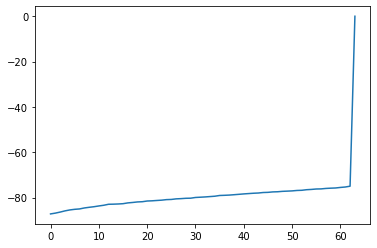

In [7]:
# First plot data about to be fed:
plt.plot(np.array(evals_dB_dataset[0,:,:,0]).flatten())

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 multiply (Multiply)         (16, 64)                  0         
                                                                 
 dense (Dense)               (16, 512)                 33280     
                                                                 
 leaky_re_lu (LeakyReLU)     (16, 512)                 0         
                                                                 
 dense_1 (Dense)             (16, 256)                 131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (16, 256)                 0    

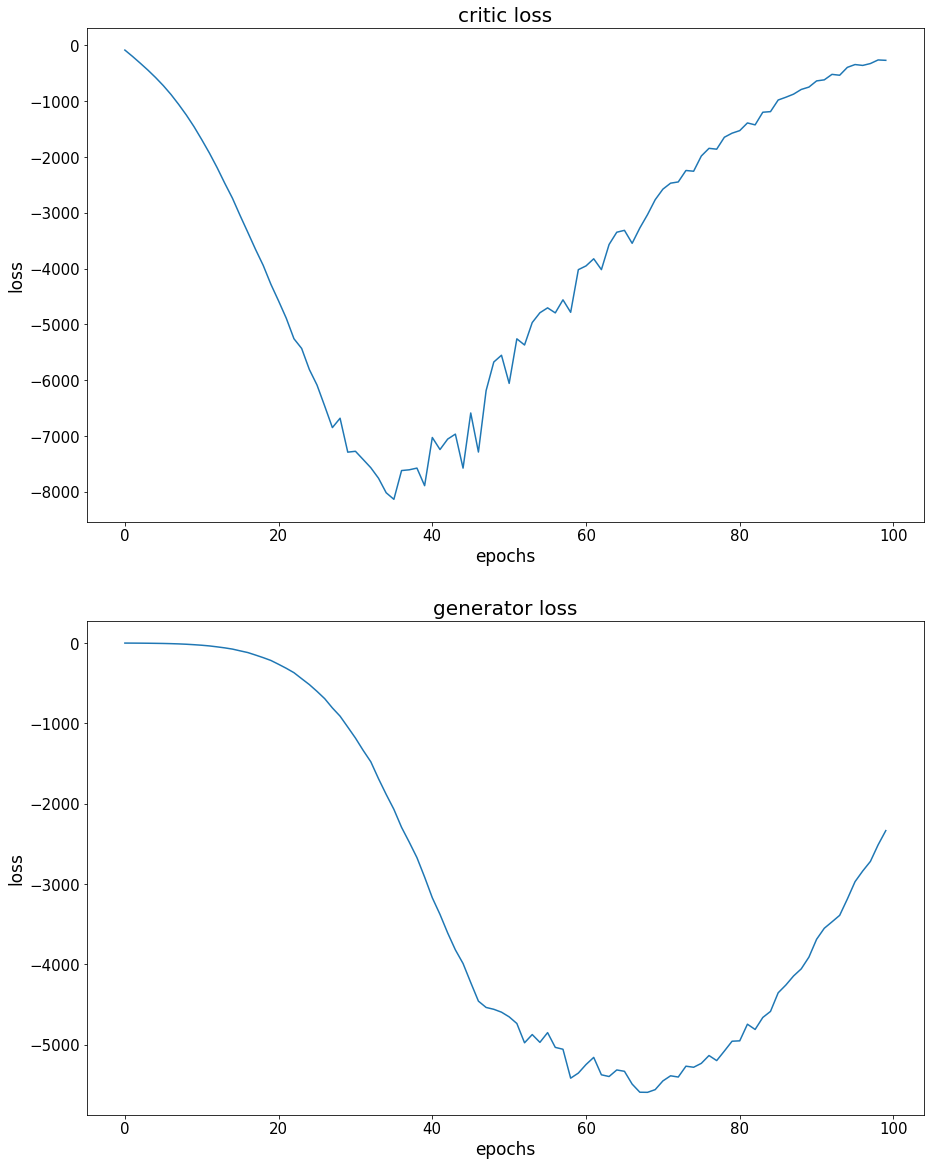

In [8]:
# Generating eigenvalues

# Creating GAN
evals_dB_wgangp = evals_dB_WGANGP()

# Compiling GAN
evals_dB_wgangp.compile()

# Getting directories for callbacks
filename = "evals_dB_wgangp" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


start = time.time()

# Training GAN
history1 = evals_dB_wgangp.fit(
    evals_dB_dataset,
    batch_size=BATCH_SIZE,
    epochs=100,
    steps_per_epoch=1, #TODO change back to 5
    callbacks=[tensorboard_callback, checkpoint_callback]
)

diff = time.time() - start
print(f"training took {diff}s")


plot_loss(history1)



In [9]:
# Generating fake sample (before fine-tuning)

_, bft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)

bft_evals_dB = np.array(bft_evals_dB[0, :, :, 0]).flatten() # convert sample from (1,8,8,1) to (64,)
bft_evals = unlevelify(bft_evals_dB)

1/1 [==============================] - 0s 184ms/step
tf.Tensor(1924.6367, shape=(), dtype=float32)
real eigenvalues found


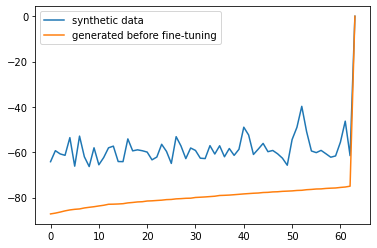

In [10]:
plt.plot(bft_evals_dB, label="synthetic data")
plt.plot(np.array(evals_dB_dataset[0,:,:,0]).flatten(), label="generated before fine-tuning")
plt.legend()

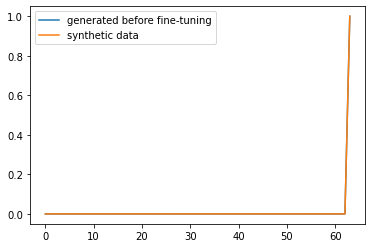

In [11]:
plt.plot(bft_evals, label="generated before fine-tuning")
plt.plot(10**np.array(evals_dB_dataset[0,:,:,0]).flatten(), label="synthetic data")
plt.legend()

The second step is to train further the Wasserstein GAN using this time really measurement

Epoch 1/200
5/5 [==============================] - 1s 130ms/step - c_loss: 173.4480 - g_loss: -1096.8482
Epoch 2/200
5/5 [==============================] - 1s 114ms/step - c_loss: -188.6351 - g_loss: 354.6106
Epoch 3/200
5/5 [==============================] - 0s 63ms/step - c_loss: -422.6543 - g_loss: 1498.9641
Epoch 4/200
5/5 [==============================] - 1s 133ms/step - c_loss: -360.5146 - g_loss: 1986.3723
Epoch 5/200
5/5 [==============================] - 1s 110ms/step - c_loss: -227.0827 - g_loss: 1540.2967
Epoch 6/200
5/5 [==============================] - 0s 91ms/step - c_loss: -171.8729 - g_loss: 586.7972
Epoch 7/200
5/5 [==============================] - 0s 66ms/step - c_loss: -139.2685 - g_loss: -8.3225
Epoch 8/200
5/5 [==============================] - 0s 74ms/step - c_loss: -97.5680 - g_loss: 3.2179
Epoch 9/200
5/5 [==============================] - 0s 88ms/step - c_loss: -66.2418 - g_loss: 143.6614
Epoch 10/200
5/5 [==============================] - 0s 87ms/step - c_l

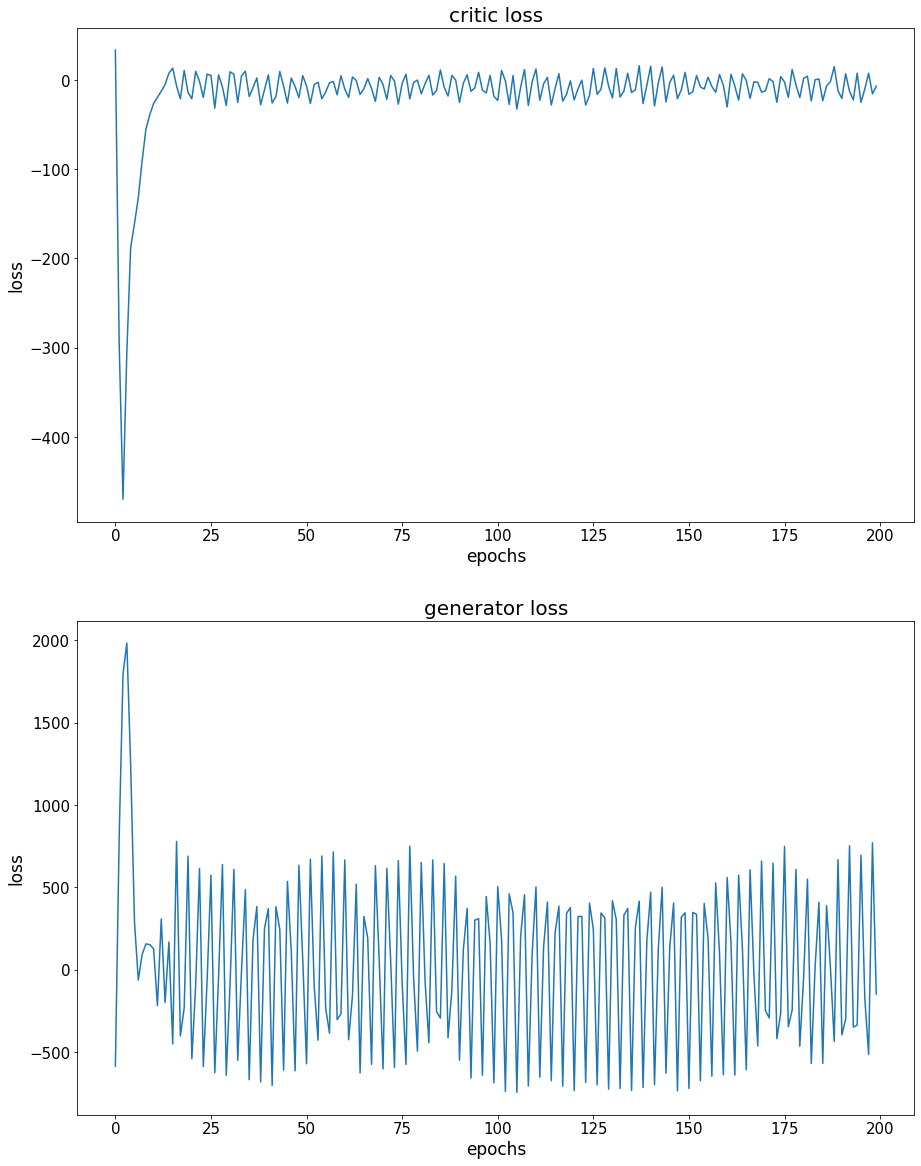

training took 81.12206673622131s


In [12]:
# Creating GAN
#evals_dB_wgangp = evals_dB_WGANGP()

# Compiling GAN
#evals_dB_wgangp.compile()

start = time.time()

history2 = evals_dB_wgangp.fit(
    measurement_evals_dB_dataset,
    batch_size=BATCH_SIZE,
    epochs=200,
    steps_per_epoch=5,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history2)

diff = time.time() - start
print(f"training took {diff}s")


Finally the obtained samples can be plotted

index=4770
index=1662
1/1 [==============================] - 0s 35ms/step
tf.Tensor(146.34033, shape=(), dtype=float32)
real eigenvalues found


Text(0.5, 0.98, 'Eigenvalues')

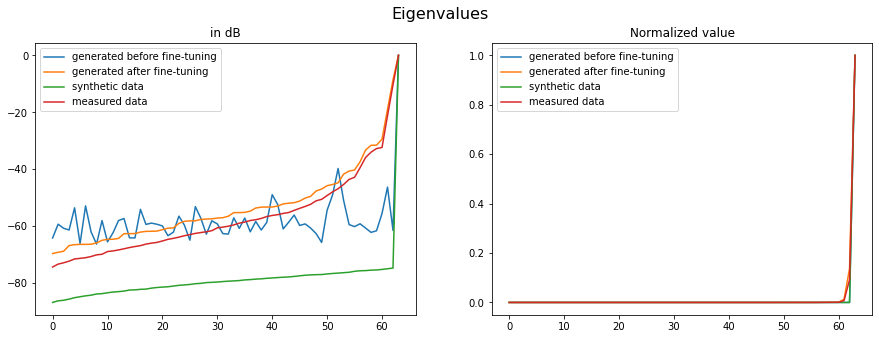

In [13]:
# Creating and plotting fake sample after fine-tuning

# Getting data from dataset
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

evals_ex = normalize_evals(evals_dataset[random_index])
evals_ex = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_ex_dB = levelify(evals_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)




_, aft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)

aft_evals_dB = np.sort(np.array(aft_evals_dB[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
aft_evals = unlevelify(aft_evals_dB)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,2)
plt.title("Normalized value")
plt.plot(bft_evals, label="generated before fine-tuning")
plt.plot(aft_evals, label="generated after fine-tuning")
plt.plot(evals_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")
plt.legend()


plt.subplot(1,2,1)
plt.title("in dB")
plt.plot(bft_evals_dB, label="generated before fine-tuning")
plt.plot(aft_evals_dB, label="generated after fine-tuning")
plt.plot(evals_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.legend()

fig.suptitle('Eigenvalues', fontsize=16)

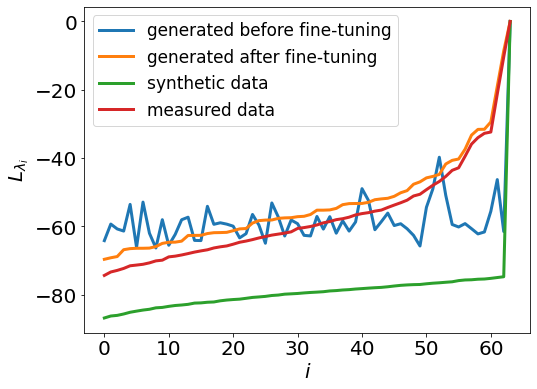

In [14]:
# For report plotting sample for fig

title_fontsize = 20
axis_fontsize = 20
nb_fontsize = 20
legend_fontsize = 17
linewidth = 3


fig = plt.figure(figsize=(8,6))

"""
plt.subplot(121)
plt.title("Scaled Eigenvalues", fontsize=title_fontsize)
plt.plot(unlevelify(bft_evals_dB), label="generated before fine-tuning", linewidth=2)
plt.plot(unlevelify(aft_evals_dB), label="generated after fine-tuning", linewidth=2)
plt.plot(unlevelify(evals_ex_dB), label="synthetic data", linewidth=2)
plt.plot(unlevelify(measurement_evals_ex_dB), label="measured data", linewidth=2)
plt.ylabel(r'$\lambda_i$', fontsize=axis_fontsize)
plt.xlabel(r'$i$', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.subplot(122)
plt.title("Level of Eigenvalues", fontsize=title_fontsize)
"""
plt.plot(bft_evals_dB, label="generated before fine-tuning", linewidth=linewidth)
plt.plot(aft_evals_dB, label="generated after fine-tuning", linewidth=linewidth)
plt.plot(evals_ex_dB, label="synthetic data", linewidth=linewidth)
plt.plot(measurement_evals_ex_dB, label="measured data", linewidth=linewidth)
plt.ylabel(r'$L_{\lambda_i}$', fontsize=axis_fontsize)
plt.xlabel(r'$i$', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

#plt.suptitle("Eigenvalues", fontsize=20)

#plt.savefig("samples_evals_dB_wgangp.pdf")


(array([-500., -400., -300., -200., -100.,    0.,  100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

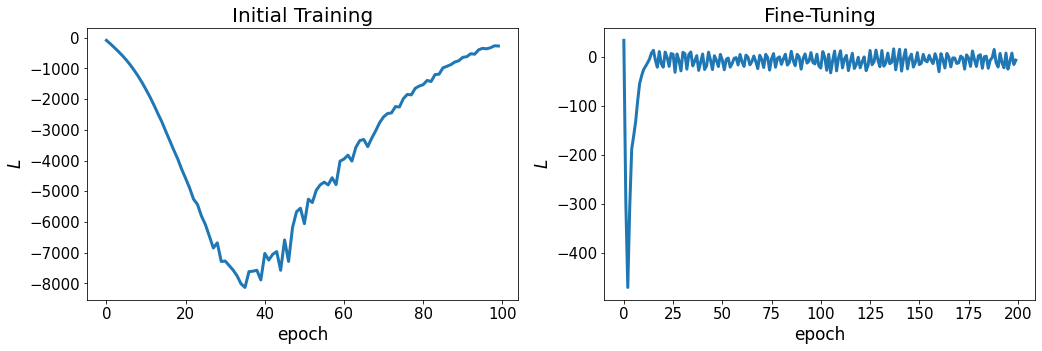

In [15]:
# plotting both loss

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15

fig = plt.figure(figsize=(17,5))
plt.subplot(121)
plt.title('Initial Training', fontsize=title_fontsize)
plt.plot(history1.history['c_loss'], linewidth=3)
plt.ylabel(r'$L$', fontsize=axis_fontsize)
plt.xlabel('epoch', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)


plt.subplot(122)
plt.title('Fine-Tuning', fontsize=title_fontsize)
plt.plot(history2.history['c_loss'], linewidth=3)
plt.ylabel(r'$L$', fontsize=axis_fontsize)
plt.xlabel('epoch', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)

#plt.savefig("loss_evals_dB_wgangp.pdf")

1/1 [==============================] - 0s 62ms/step
tf.Tensor(153.02904, shape=(), dtype=float32)
real eigenvalues found


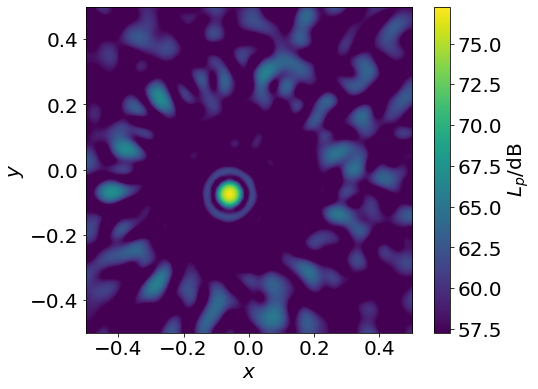

In [16]:

# Data augmentation
NUMCHANNELS = 64
NUMFREQ = 1

# Compute Augmented CSM
evecs = tf.concat([noise_evecs_dataset, main_evecs_dataset],axis=-2)
augmented_csm = get_augmented_csm_from_eval(evals_dB_wgangp, evecs)
augmented_csm = np.reshape(augmented_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

# Compute normal CSM
fig = plt.figure(figsize=(8,6))

#plt.title("Augmented CSM", fontsize = 15)
beamform(augmented_csm, HELMOTZ_NUMBER, False)


#plt.savefig("beamforming_map_data_augmentation_evals.pdf")

plt.savefig("data_augmentation_evals_augmented_csm.pdf")

In [17]:
print(measurement_evals_dB_dataset.shape)

measurement_evals_dB_dataset_flatten = []

for i in measurement_evals_dB_dataset:
    i_flatten = np.sort(np.array(i[:, :, 0]).flatten())
    measurement_evals_dB_dataset_flatten.append(i_flatten)
measurement_evals_dB_dataset_flatten = np.array(measurement_evals_dB_dataset_flatten)
print(measurement_evals_dB_dataset_flatten.shape)

(3200, 8, 8, 1)
(3200, 64)


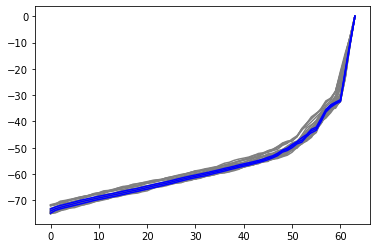

In [18]:
for a in level_decay:
    plt.plot(a, color= "gray")

measurement_evals_dB_dataset_average = np.mean(measurement_evals_dB_dataset_flatten, axis=0)
measurement_evals_dB_dataset_95per = np.percentile(measurement_evals_dB_dataset_flatten,q=95, axis=0)
measurement_evals_dB_dataset_5per = np.percentile(measurement_evals_dB_dataset_flatten,q=5, axis=0)
plt.plot(measurement_evals_dB_dataset_average, color= "blue")
plt.plot(measurement_evals_dB_dataset_95per, color= "blue")
plt.plot(measurement_evals_dB_dataset_5per, color= "blue")



In [19]:
sample_evals_dB_dataset_flatten = []

for i in range(500):
    print(f"{i}================================")
    _, aft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=1)
    i_flatten = np.sort(np.array(aft_evals_dB[0, :, :, 0]).flatten())
    sample_evals_dB_dataset_flatten.append(i_flatten)

sample_evals_dB_dataset_flatten = np.array(sample_evals_dB_dataset_flatten)


print(sample_evals_dB_dataset_flatten.shape)
 

0================================
1/1 [==============================] - 0s 26ms/step
tf.Tensor(155.37358, shape=(), dtype=float32)
real eigenvalues found
1================================
1/1 [==============================] - 0s 90ms/step
tf.Tensor(151.39911, shape=(), dtype=float32)
real eigenvalues found
2================================
1/1 [==============================] - 0s 46ms/step
tf.Tensor(116.01975, shape=(), dtype=float32)
real eigenvalues found
3================================
1/1 [==============================] - 0s 52ms/step
tf.Tensor(131.9397, shape=(), dtype=float32)
real eigenvalues found
4================================
1/1 [==============================] - 0s 43ms/step
tf.Tensor(143.80916, shape=(), dtype=float32)
real eigenvalues found
5================================
1/1 [==============================] - 0s 59ms/step
tf.Tensor(143.63489, shape=(), dtype=float32)
real eigenvalues found
6================================
1/1 [==============================] 

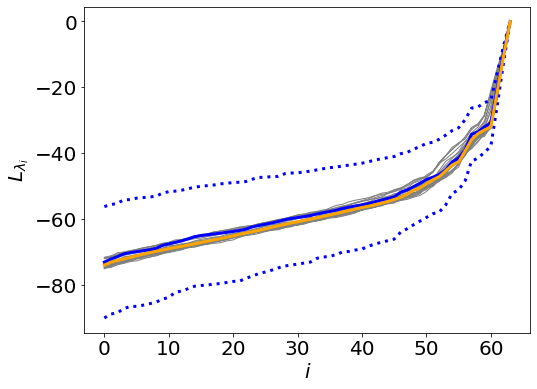

In [28]:
# For report plotting 100 for fig

title_fontsize = 20
axis_fontsize = 20
nb_fontsize = 20
legend_fontsize = 17
linewidth = 3

fig = plt.figure(figsize=(8,6))

for i in level_decay:
    plt.plot(i, color ='gray', linewidth=1)


delta = 5

sample_evals_dB_dataset_average = np.mean(sample_evals_dB_dataset_flatten,axis=0)
sample_evals_dB_dataset_95per = np.percentile(sample_evals_dB_dataset_flatten,q=100-delta, axis=0)
sample_evals_dB_dataset_5per = np.percentile(sample_evals_dB_dataset_flatten,q=delta, axis=0)

plt.plot(sample_evals_dB_dataset_average, color ='blue', linewidth=linewidth)
plt.plot(sample_evals_dB_dataset_95per, color ='blue', linestyle="dotted", linewidth=linewidth)
plt.plot(sample_evals_dB_dataset_5per, color ='blue', linestyle="dotted", linewidth=linewidth)

plt.plot(measurement_evals_dB_dataset_average, color ='orange', linewidth=linewidth)
#plt.plot(measurement_evals_dB_dataset_95per, color ='orange', linestyle="dotted", linewidth=linewidth)
#plt.plot(measurement_evals_dB_dataset_5per, color ='orange', linestyle="dotted", linewidth=linewidth)

plt.ylabel(r'$L_{\lambda_i}$', fontsize=axis_fontsize)
plt.xlabel(r'$i$', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
#plt.legend(fontsize=legend_fontsize)

plt.savefig("outliers_evals_dB_wgangp.pdf")   

### Generating main Eigenvectors

In [ ]:
# Generating main component of eigenvectors

# Creating GAN
main_evecs_wgangp = main_evecs_WGANGP()

# Compiling GAN
main_evecs_wgangp.compile()

# Getting directories for callbacks
filename = "main_evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


# Training GAN
start = time.time()

history1 = main_evecs_wgangp.fit(
    main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=500,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

diff = time.time() - start
print(f"training took {diff}s")

plot_loss(history1)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.

In [ ]:
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

main_evecs_real = main_evecs[0, :, :, 0] # get real part from sample
main_evecs_imag = main_evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(main_evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(main_evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors before fine-tuning', fontsize=16) 

In [ ]:
# fine-tuning
start = time.time()
history2 = main_evecs_wgangp.fit(
    measurement_main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

diff = time.time() - start
print(f"training took {diff}s")

plot_loss(history2)

In [ ]:
_, main_evecs_after = main_evecs_wgangp.generate_evecs(nb_trial=10)

main_evecs_real_after = main_evecs_after[0, :, :, 0] # get real part from sample
main_evecs_imag_after = main_evecs_after[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(main_evecs_real_after)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(main_evecs_imag_after)
plt.colorbar()

fig.suptitle('Eigenvectors after fine-tuning', fontsize=16)


In [ ]:
# Rank I BEAMFORMING TO ASSESS QUALITY OF GENERATED DATA

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

# with WGANGP-generated data ===================================================================================

evals = evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)

_, main_evecs_after = main_evecs_wgangp.generate_evecs(nb_trial=10)

main_evecs_after = normalize_evecs(main_evecs_after)

main_evec_real = main_evecs_after[0, :, 0, 0] # get real part from sample
main_evec_imag = main_evecs_after[0, :, 0, 1] # get imaginary part from sample

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()
rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)

In [ ]:
# Plot difference between Rank I beamforming 

generated_evals = measurement_evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(generated_evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)


main_evec = normalize_evecs(measurement_main_evecs_dataset[0, :, :,:])
main_evec_real = main_evec[:, 0, 0] 
main_evec_imag = main_evec[:, 0, 1]

measurement_rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()
measurement_rank_I_csm = np.reshape(measurement_rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform_difference(rank_I_csm,
                    measurement_rank_I_csm,
                    helmotz_number=HELMOTZ_NUMBER,
                    measurement=True)
#beamform(measurement_rank_I_csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)


In [ ]:
# Plotting the beamforming map

fig = plt.figure(figsize=(8,6))

#plt.subplot(121)
#plt.title("Generated Rank I CSM", fontsize = 15)
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)

#plt.savefig("beamforming_map_main_evec_wgangp_generated.pdf")
fig = plt.figure(figsize=(8,6))
#plt.subplot(122)
#plt.title("Difference", fontsize = 15)
beamform_difference(rank_I_csm,
                    measurement_rank_I_csm,
                    helmotz_number=HELMOTZ_NUMBER,
                    measurement=True)

#fig.suptitle('Beamforming Map', fontsize=16)

#plt.savefig("beamforming_map_main_evec_wgangp_difference.pdf")

In [ ]:
fig = plt.figure(figsize=(7,6))

beamform(measurement_rank_I_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)
plt.title("Rank I CSM from measurement", fontsize = 15)

#plt.savefig("measurement_sample_rank_I_beamforming.pdf")

In [ ]:
# plotting both loss

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15

fig = plt.figure(figsize=(17,5))
plt.subplot(121)
plt.title('Initial Training', fontsize=title_fontsize)
plt.plot(history1.history['c_loss'], linewidth=3)
plt.ylabel(r'$L$', fontsize=axis_fontsize)
plt.xlabel('epoch', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)


plt.subplot(122)
plt.title('Fine-Tuning', fontsize=title_fontsize)
plt.plot(history2.history['c_loss'], linewidth=3)
plt.ylabel(r'$L$', fontsize=axis_fontsize)
plt.xlabel('epoch', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)

#plt.savefig("loss_main_evec_wgangp.pdf")

In [ ]:
# TODO: cell for data augmentation

# Data augmentation
NUMCHANNELS = 64
NUMFREQ = 1

# Compute Augmented CSM
evals = evals_dataset[0,:,:,:]
noise_evecs = noise_evecs_dataset[0,:,:,:]
augmented_csm = get_augmented_csm_from_evec(main_evecs_wgangp, evals, noise_evecs)
augmented_csm = np.reshape(augmented_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

evecs = tf.concat([noise_evecs_dataset, main_evecs_dataset],axis=-2)
evals = normalize_evals(np.sort(np.array(measurement_evals_dataset[0, :, :, 0]).flatten()))
csm = get_csm(evecs[0,:,:,0], evecs[0,:,:,1], evals)
csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))
plt.plot(levelify(evals))


# Compute normal CSM
fig = plt.figure(figsize=(8,6))

#plt.subplot(121)
#plt.title("Augmented CSM", fontsize = 15)
beamform(augmented_csm, HELMOTZ_NUMBER, False)


#plt.subplot(122)
#plt.title("Difference", fontsize = 15)
#beamform_difference(augmented_csm, csm, HELMOTZ_NUMBER, False)

#fig.suptitle('Beamforming Map', fontsize=16)

plt.savefig("data_augmentation_evecs_augmented_csm.pdf")


In [ ]:
score_list = []
evecs_list = []

nb_sample = 5000

for i in range(nb_sample):
    print(f"=== {i} ======================================================")
    score, main_evecs_after = main_evecs_wgangp.generate_evecs(nb_trial=1)

    score_list.append(score)
    evecs_list.append(main_evecs_after)

score_list = np.array(score_list)
evecs_list = np.array(evecs_list)

In [ ]:
index = np.argmin(score_list)

print(f"min_score={score_list[index]}")

outlier_main_evec = np.array(evecs_list[index])

In [ ]:
# Rank I BEAMFORMING TO ASSESS QUALITY OF GENERATED DATA

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

# with WGANGP-generated data ===================================================================================

evals = evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)

#_, main_evecs_after = main_evecs_wgangp.generate_evecs(nb_trial=10)

#main_evec = normalize_evecs(outlier_main_evec)

main_evec_real = outlier_main_evec[0, :, 0, 0] # get real part from sample
main_evec_imag = outlier_main_evec[0, :, 0, 1] # get imaginary part from sample

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()
rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

fig = plt.figure(figsize=(8,6)) 
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER, measurement=True)

plt.savefig("outliers_main_evec.pdf")

### Generating noise eigenvectors 

In [ ]:
# Generating noise component of eigenvectors

# Creating GAN
latent_dim = 2048
n_crit = 7
noise_evecs_wgangp = noise_evecs_WGANGP(latent_dim=latent_dim, critic_extra_steps=n_crit)

# Compiling GAN
noise_evecs_wgangp.compile()

# Getting directories for callbacks
filename = f"noise_evecs_wgangp_latent={latent_dim}_n_crit={n_crit}" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )




# Training GAN
history = noise_evecs_wgangp.fit(
    noise_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=1000,
    steps_per_epoch=500,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history)

Generating eigenvectors before fine-tuning

In [ ]:
# Creating and plotting fake sample

_, noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

print(noise_evecs.shape)
print(main_evecs.shape)

evecs = tf.concat([noise_evecs, main_evecs],axis=-3)


evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors', fontsize=16)

Fine-tuning with measurements

In [ ]:
history = noise_evecs_wgangp.fit(
    measurement_noise_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=100,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)
plot_loss(history)

Plotting Eigenvectors (after fine-tuning) 

In [ ]:
_, noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

evecs = tf.concat([noise_evecs, main_evecs],axis=-3)


evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors', fontsize=16)

# Performing beamforming on fully generated data
1. Using a full CSM

In [ ]:
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, generated_main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

generated_evecs = tf.concat([generated_noise_evecs, generated_main_evecs], axis=-3)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
#evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
#evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample
evecs_real = generated_evecs[ :, :, 0] #TODO: delete
evecs_imag = generated_evecs[ :, :, 1] #TODO: delete


csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)

2. Using a Rank I CSM

In [ ]:
def get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec):

    main_evec = tf.complex(main_evec_real, main_evec_imag)
    """main_evec = main_evec[:,tf.newaxis]
    print(f"main_evec.shape{main_evec.shape}")
    main_evec_H = tf.linalg.adjoint(main_evec)
    print(f"main_evec_H.shape{main_evec_H.shape}")"""
    
    main_evec_conj = tf.math.conj(main_evec) 
    
    # reshaping eigenvalues
    mask = np.zeros(shape=evals_vec.shape, dtype='float32')
    mask[0] = 1
    mask = tf.convert_to_tensor(mask)    
    main_evals_vec = tf.math.multiply(evals_vec, mask)
    evals_real = tf.linalg.diag(main_evals_vec)
    evals_imag = tf.zeros(shape=evals_real.shape) # because evals also need to be complex to be multiplied with complex matrix
    evals = tf.complex(evals_real, evals_imag)
    
    # performing the multiplication
    #tmp_mult = tf.linalg.matmul(main_evec,evals)
    #full_mult = tf.linalg.matmul(tmp_mult,main_evec_H)
    
    full_mult = tf.einsum('i, jk, l -> il',  main_evec, evals, main_evec_conj)
    
    #print(tmp_mult.shape)
    print(full_mult.shape)
    return full_mult
    

In [ ]:
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_main_evec = main_evecs_wgangp.generate_evecs(nb_trial=10)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
main_evec_real = generated_main_evec[0,0, :, 0] 
main_evec_imag = generated_main_evec[0,0, :, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(rank_I_csm)

In [ ]:
# test: synthetic data
from beamforming import beamform, get_csm

max_value = min(evals_dataset.shape[0],main_evecs_dataset.shape[0]) 
index = np.random.randint(0, max_value)
print(f"index={index}")

generated_evals = evals_dataset[index, :, :,:]
generated_main_evec = main_evecs_dataset[index, :, :,:]

"""
generated_evals = measurement_evals_dataset[index, :, :,:]
generated_main_evec = measurement_main_evecs_dataset[index, :, :,:]
"""

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[ :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
main_evec_real = generated_main_evec[0, :, 0] 
main_evec_imag = generated_main_evec[0, :, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=False)

In [ ]:
# test: measurement data
from beamforming import beamform, get_csm


max_value = min(measurement_evals_dataset.shape[0],measurement_main_evecs_dataset.shape[0]) 
index = np.random.randint(0, max_value)
print(f"index={index}")


generated_evals = measurement_evals_dataset[index, :, :,:]
generated_main_evec = measurement_main_evecs_dataset[index, :, :,:]

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[ :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
main_evec_real = generated_main_evec[0, :, 0] 
main_evec_imag = generated_main_evec[0, :, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)